In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest, r_regression

from plotly.subplots import make_subplots

import os

# Stage 1

## 1A : Brief Description of Data

### The World Happiness Report

* The World Happiness Report reviews the state of happiness across a multitude of countries based on a series of questions, with answers rated between 0 and 10. Six variables are then used to explain the overall 'happiness', comparing the outcome against a fictional country called Dystopia, which is a culmination of all the lowest ratings gathered that year.

https://worldhappiness.report/about/

* The data and inforation regrarding it was sourced from : https://worldhappiness.report/data/


In [2]:
happiness_report = pd.read_excel('data/DataForTable2.1WHR2023.xls')

### 1.1A Summary Statistics: Happiness Report

In [3]:
happiness_report.describe()

,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
count,2199.000000,2199.000000,2179.000000,2186.000000,2145.000000,2166.000000,2126.000000,2083.000000,2175.000000,2183.000000
mean,2014.161437,5.479226,9.389766,0.810679,63.294583,0.747858,0.000096,0.745195,0.652143,0.271501
std,4.718736,1.125529,1.153387,0.120952,6.901104,0.140150,0.161083,0.185837,0.105922,0.086875
min,2005.000000,1.281271,5.526723,0.228217,6.720000,0.257534,-0.337527,0.035198,0.178886,0.082737
25%,2010.000000,4.646750,8.499764,0.746609,59.119999,0.656528,-0.112116,0.688139,0.571684,0.207660
50%,2014.000000,5.432437,9.498955,0.835535,65.050003,0.769821,-0.022671,0.799654,0.663063,0.260671
75%,2018.000000,6.309460,10.373216,0.904792,68.500000,0.859382,0.092070,0.868827,0.737936,0.322894
max,2022.000000,8.018934,11.663788,0.987343,74.474998,0.985178,0.702708,0.983276,0.883586,0.704590


### 1.2A Column Headers: Happiness Report


In [4]:
list(happiness_report)

['Country name',
 'year',
 'Life Ladder',
 'Log GDP per capita',
 'Social support',
 'Healthy life expectancy at birth',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption',
 'Positive affect',
 'Negative affect']

### 1.3B Graphs : Happiness Report

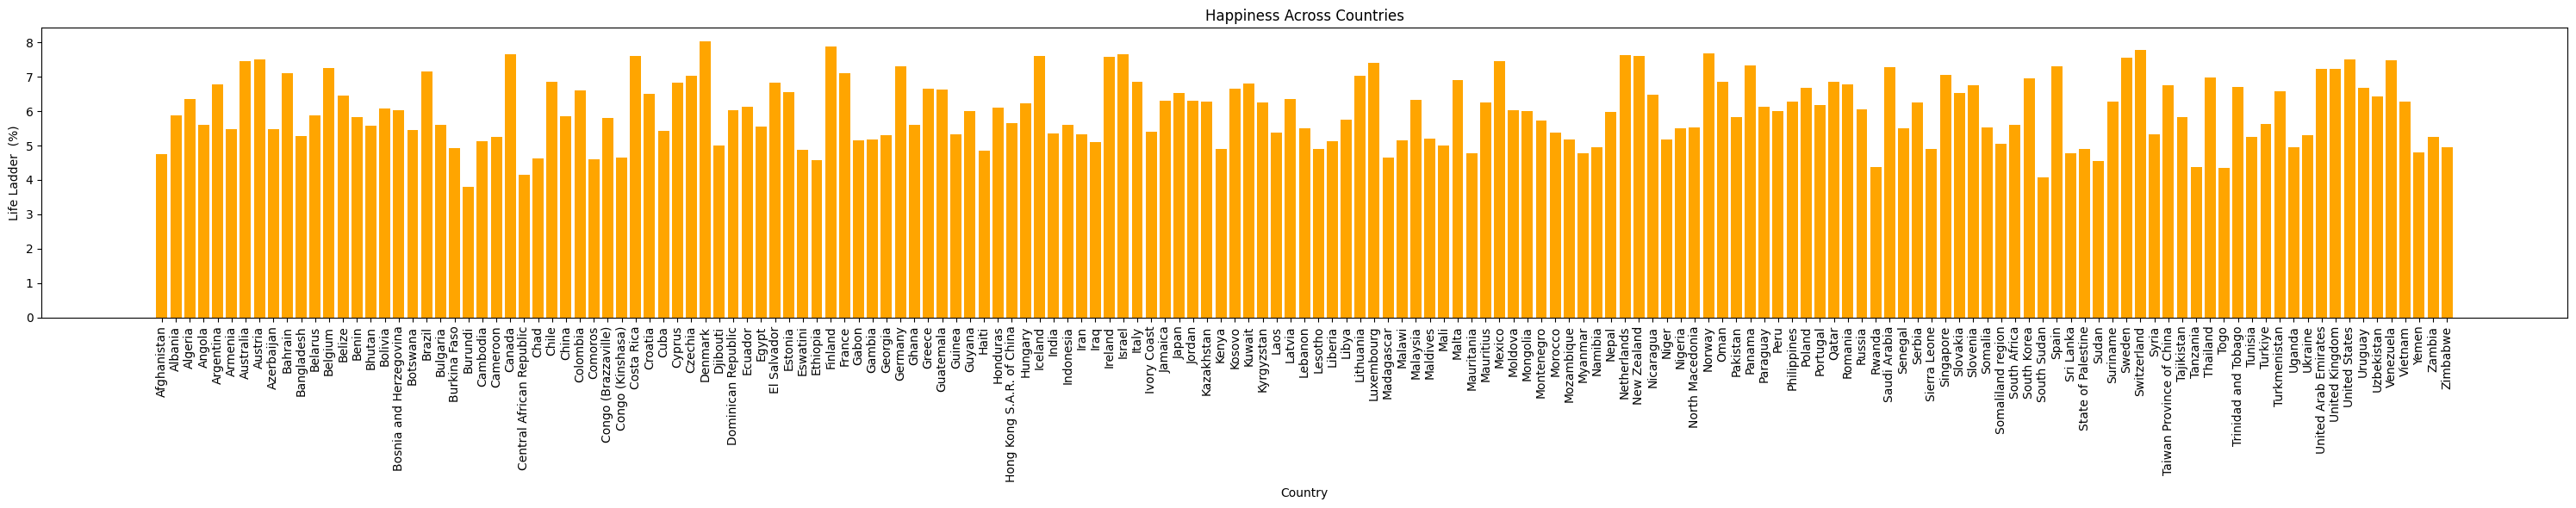

In [5]:
countries = happiness_report['Country name']
happiness = happiness_report['Life Ladder']

plt.figure(figsize=(30, 6))
plt.bar(countries, happiness, color='orange')
plt.xlabel('Country')
plt.ylabel('Life Ladder  (%)')
plt.title('Happiness Across Countries')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 1B : Brief Description of Data



### World Educational Data

* The World Educational Data contains information on various educational indicators from countries around the world. It includes a range of variables related to education, such as literacy rates, enrollment rates, birth rates, and unemployment rates.

* The data is taken from sources which were last updated in 2021.

* The data and inforation regarding it was sourced from : https://www.kaggle.com/datasets/nelgiriyewithana/world-educational-data


In [6]:
education_report = pd.read_excel('data/education_world.xls')

### 1.1B Summary Statistics: Education Report

In [7]:
education_report.describe()

,Latitude,Longitude,OOSR_Pre0Primary_Age_Male,OOSR_Pre0Primary_Age_Female,OOSR_Primary_Age_Male,OOSR_Primary_Age_Female,OOSR_Lower_Secondary_Age_Male,OOSR_Lower_Secondary_Age_Female,OOSR_Upper_Secondary_Age_Male,OOSR_Upper_Secondary_Age_Female,...,Primary_End_Proficiency_Reading,Primary_End_Proficiency_Math,Lower_Secondary_End_Proficiency_Reading,Lower_Secondary_End_Proficiency_Math,Youth_15_24_Literacy_Rate_Male,Youth_15_24_Literacy_Rate_Female,Birth_Rate,Gross_Primary_Education_Enrollment,Gross_Tertiary_Education_Enrollment,Unemployment_Rate
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,...,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,25.081422,55.166928,19.658416,19.282178,5.282178,5.569307,8.707921,8.831683,20.292079,19.975248,...,10.717822,10.376238,25.787129,24.450495,35.801980,35.084158,18.914010,94.942574,34.392574,6.000000
std,16.813639,45.976287,25.007604,25.171147,9.396442,10.383092,13.258203,14.724717,21.485592,23.140376,...,24.866101,22.484423,33.181384,31.965467,45.535186,45.249643,10.828184,29.769338,29.978206,5.273136
min,0.023559,0.824782,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.685062,18.665678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.355000,97.200000,9.000000,2.302500
50%,21.207861,43.518091,9.000000,7.000000,1.000000,1.000000,2.000000,2.000000,15.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.550000,101.850000,24.850000,4.585000
75%,39.901792,77.684945,31.000000,30.000000,6.000000,6.750000,12.750000,10.750000,32.750000,30.000000,...,0.000000,0.000000,56.750000,50.750000,94.000000,96.750000,27.692500,107.300000,59.975000,8.655000
max,64.963051,178.065032,96.000000,96.000000,58.000000,67.000000,61.000000,70.000000,84.000000,89.000000,...,99.000000,89.000000,89.000000,94.000000,100.000000,100.000000,46.080000,142.500000,136.600000,28.180000


### 1.2B Column Headers : Education Report

In [8]:
list(education_report)

['Countries and areas',
 'Latitude ',
 'Longitude',
 'OOSR_Pre0Primary_Age_Male',
 'OOSR_Pre0Primary_Age_Female',
 'OOSR_Primary_Age_Male',
 'OOSR_Primary_Age_Female',
 'OOSR_Lower_Secondary_Age_Male',
 'OOSR_Lower_Secondary_Age_Female',
 'OOSR_Upper_Secondary_Age_Male',
 'OOSR_Upper_Secondary_Age_Female',
 'Completion_Rate_Primary_Male',
 'Completion_Rate_Primary_Female',
 'Completion_Rate_Lower_Secondary_Male',
 'Completion_Rate_Lower_Secondary_Female',
 'Completion_Rate_Upper_Secondary_Male',
 'Completion_Rate_Upper_Secondary_Female',
 'Grade_2_3_Proficiency_Reading',
 'Grade_2_3_Proficiency_Math',
 'Primary_End_Proficiency_Reading',
 'Primary_End_Proficiency_Math',
 'Lower_Secondary_End_Proficiency_Reading',
 'Lower_Secondary_End_Proficiency_Math',
 'Youth_15_24_Literacy_Rate_Male',
 'Youth_15_24_Literacy_Rate_Female',
 'Birth_Rate',
 'Gross_Primary_Education_Enrollment',
 'Gross_Tertiary_Education_Enrollment',
 'Unemployment_Rate']

### 1.3B Graphs : Education Report

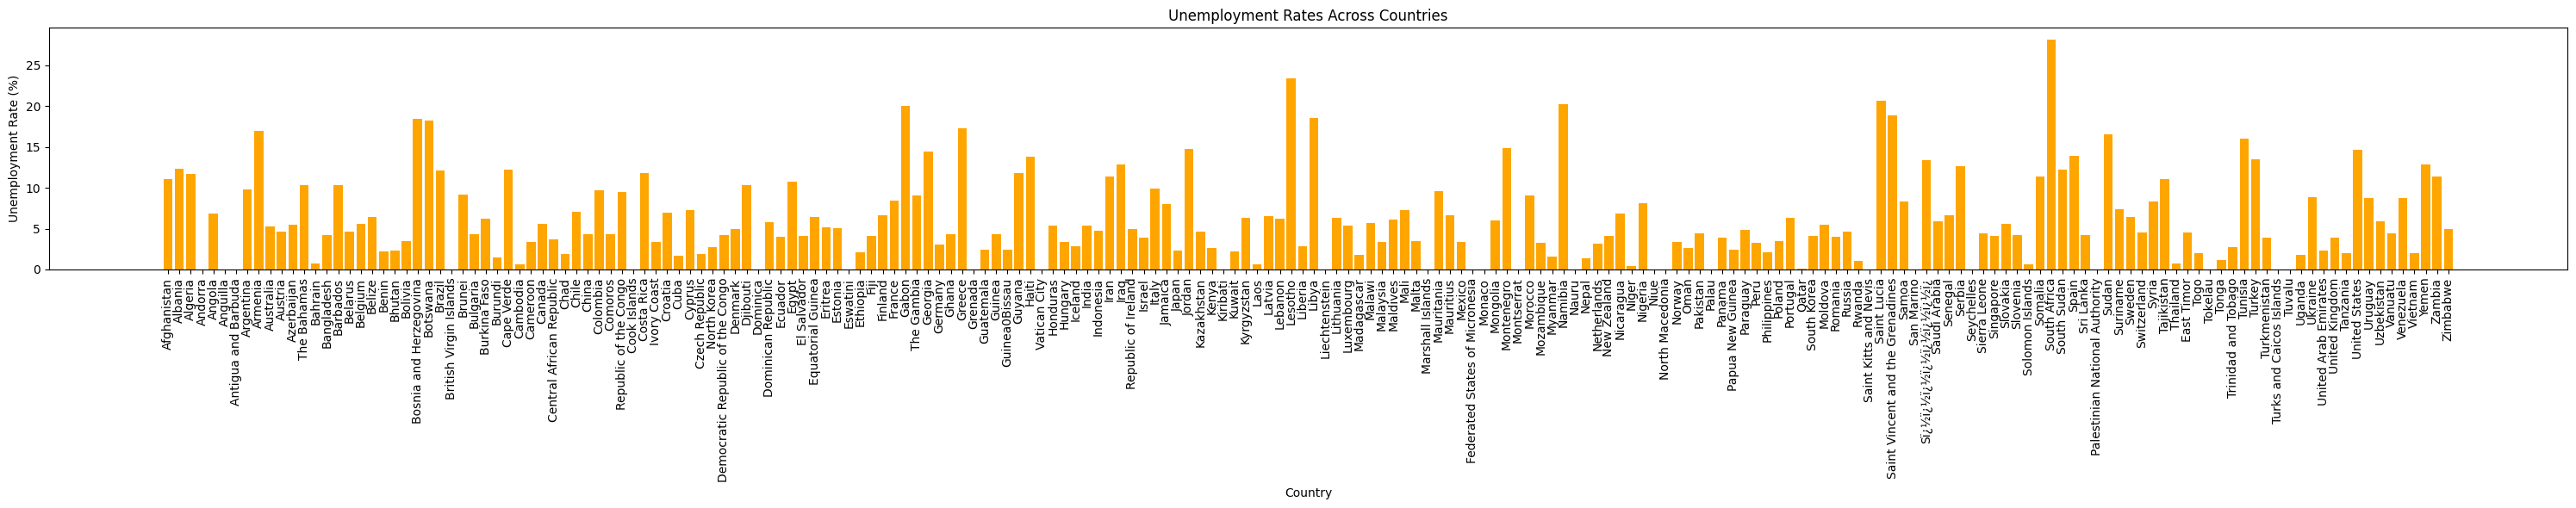

In [9]:
countries = education_report['Countries and areas']
unemployment_rates = education_report['Unemployment_Rate']

plt.figure(figsize=(30, 6))
plt.bar(countries, unemployment_rates, color='orange')
plt.xlabel('Country')
plt.ylabel('Unemployment Rate (%)')
plt.title('Unemployment Rates Across Countries')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### 1.4 Linking Data from Different Sources

I am going to explore the correlation between educational 'success' and perceived happiness. I also want to examine gender disparity in education and its potential effect on purported happiness.

I aim to develop a predictive model to forecast happiness scores based on gender disparities in education indicators, such as enrollment rates and literacy rates between males and females.

# Stage 2

## Justification for Predicting Happiness Scores

Happiness is an important indicator of human well-being and quality of life. Gaining an understanding of the critical factors that dictate happiness, as well as the correlation between education and gender, could offer fascinating insights into areas of society that could be elevated and improved

# Stage 3

## 3.1a Clean the Data : Happiness Dataset

### 3.1.1a Check for Missing Values

In [10]:
print(happiness_report.isnull().sum())

Country name                          0
year                                  0
Life Ladder                           0
Log GDP per capita                   20
Social support                       13
Healthy life expectancy at birth     54
Freedom to make life choices         33
Generosity                           73
Perceptions of corruption           116
Positive affect                      24
Negative affect                      16
dtype: int64


In [11]:
percent_columns_null = (happiness_report.isnull().sum() / len(happiness_report)) * 100

In [12]:
print("Percentage of null values in the Data")
print(percent_columns_null.apply(lambda x: "{:.2f}%".format(x)))


Percentage of null values in the Data
Country name                        0.00%
year                                0.00%
Life Ladder                         0.00%
Log GDP per capita                  0.91%
Social support                      0.59%
Healthy life expectancy at birth    2.46%
Freedom to make life choices        1.50%
Generosity                          3.32%
Perceptions of corruption           5.28%
Positive affect                     1.09%
Negative affect                     0.73%
dtype: object


The majority of columns have a number of null values, but overall the percentage is low. I decided to perform imputation using the mean value of the column, using SimpleImputer from the scikitlearn module.

In [13]:
columns_with_missing_values = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect']

imputer = SimpleImputer(strategy='mean')
happiness_report[columns_with_missing_values] = imputer.fit_transform(happiness_report[columns_with_missing_values])

After performing imputation the values are no longer null

In [14]:
happiness_report.isnull().sum()

Country name                        0
year                                0
Life Ladder                         0
Log GDP per capita                  0
Social support                      0
Healthy life expectancy at birth    0
Freedom to make life choices        0
Generosity                          0
Perceptions of corruption           0
Positive affect                     0
Negative affect                     0
dtype: int64

### 3.1.2a Check for Duplicates

In [15]:
print(happiness_report.duplicated().sum())

0


### 3.1.3a Check for Inconsistencies

In [16]:
print("Number of Unique Country Names: ", happiness_report['Country name'].nunique())
print("Total Number of Country Names: ", happiness_report['Country name'].shape[0])
print("Count of Unique Country Names", happiness_report['Country name'].value_counts())

Number of Unique Country Names:  165
Total Number of Country Names:  2199
Count of Unique Country Names Country name
Lebanon       17
Indonesia     17
Kyrgyzstan    17
Kenya         17
Kazakhstan    17
              ..
Maldives       1
Guyana         1
Oman           1
Suriname       1
Cuba           1
Name: count, Length: 165, dtype: int64


## 3.1b Clean the Data : Education Dataset

### 3.1.1b Check for Missing Values

In [17]:
print(education_report.isnull().sum())

Countries and areas                        0
Latitude                                   0
Longitude                                  0
OOSR_Pre0Primary_Age_Male                  0
OOSR_Pre0Primary_Age_Female                0
OOSR_Primary_Age_Male                      0
OOSR_Primary_Age_Female                    0
OOSR_Lower_Secondary_Age_Male              0
OOSR_Lower_Secondary_Age_Female            0
OOSR_Upper_Secondary_Age_Male              0
OOSR_Upper_Secondary_Age_Female            0
Completion_Rate_Primary_Male               0
Completion_Rate_Primary_Female             0
Completion_Rate_Lower_Secondary_Male       0
Completion_Rate_Lower_Secondary_Female     0
Completion_Rate_Upper_Secondary_Male       0
Completion_Rate_Upper_Secondary_Female     0
Grade_2_3_Proficiency_Reading              0
Grade_2_3_Proficiency_Math                 0
Primary_End_Proficiency_Reading            0
Primary_End_Proficiency_Math               0
Lower_Secondary_End_Proficiency_Reading    0
Lower_Seco

### 3.1.1b Check for Duplicates

In [18]:
print(education_report.duplicated().sum())

0


### 3.1.3b Check for Inconsistencies

In [19]:
print("Number of Unique Country Names", education_report['Countries and areas'].nunique())
print("Total Number of Country Names", education_report['Countries and areas'].shape)

Number of Unique Country Names 202
Total Number of Country Names (202,)


### 3.1.4 Collate based on Country Names

hapiness has 165, education has 202. Compare and print unmatching countries

In [20]:
happiness_countries = happiness_report['Country name'].unique()
education_countries = education_report['Countries and areas'].unique()

matching_countries = set(happiness_countries).intersection(education_countries)

print("Matching Countries:")
for country in matching_countries:
    print(country)

print("Total matching countries: ", len(matching_countries))

Matching Countries:
United States
Denmark
Russia
Pakistan
Italy
Philippines
Somalia
Mongolia
Paraguay
Maldives
Uruguay
Saudi Arabia
Chile
Belarus
Laos
Tajikistan
Tunisia
Tanzania
Moldova
Algeria
Guinea
Finland
Honduras
Luxembourg
Angola
Haiti
Malta
Mexico
Vietnam
Gabon
Greece
Cyprus
Venezuela
Spain
Thailand
Belgium
Iceland
Bangladesh
Mali
United Arab Emirates
Central African Republic
Bolivia
Botswana
Lithuania
Serbia
Australia
Kenya
Slovenia
Uzbekistan
Singapore
Brazil
Germany
Argentina
Lesotho
Ghana
Mauritania
Oman
Mauritius
Japan
Egypt
Mozambique
Namibia
Syria
Kazakhstan
Montenegro
Sierra Leone
Dominican Republic
Djibouti
Guyana
Malawi
Niger
South Africa
Guatemala
Ecuador
Kuwait
China
Georgia
Ukraine
Norway
El Salvador
Nicaragua
Iran
Sudan
Benin
Eswatini
Azerbaijan
Bosnia and Herzegovina
Uganda
Nepal
Morocco
Qatar
Latvia
Bahrain
Israel
Chad
Libya
Switzerland
Rwanda
Lebanon
Armenia
Nigeria
Kyrgyzstan
South Korea
Myanmar
Cameroon
Colombia
Madagascar
Panama
South Sudan
Cambodia
Croatia


## 3.2 Link the Datasets  : Happiness dataset and Education Dataset

* Can merge on a common column (country) pd.merge()
* Will need to ensure the column names match
* Want to remove the log/lat from education as not necessary.
* possibly collate school data ?
* Also remove unmatching country rows.

In [21]:
new_happiness_report = happiness_report[happiness_report['Country name'].isin(matching_countries)]

In [22]:
new_education_report = education_report[education_report['Countries and areas'].isin(matching_countries)]

In [23]:
new_education_report['Countries and areas'].nunique()

154

In [24]:
# remove columns...
new_education_report = new_education_report.drop(columns=['Latitude ', 'Longitude'])

In [25]:
new_education_report.rename(columns={'Countries and areas': 'Country name'}, inplace=True)
new_education_report.rename(columns={'Countries and areas': 'Country name'}, inplace=True)

Merge the two tables on the column name 'Country name' after changing the column name in the eductaion dataset.

In [26]:
merged_table = new_happiness_report.merge(new_education_report, on='Country name', how='inner')

As the education report is based off date from 2021 I decided to remove all other years.

In [27]:
merged_table = merged_table[merged_table['year'] == 2021]
merged_table.drop(columns=['year'], inplace=True)

Graph showing correlation between Happiness score (life ladder) and gross primary vs gross tertiary education

In [28]:
happiness_score = merged_table['Life Ladder']
gross_primary = merged_table['Gross_Primary_Education_Enrollment']
gross_sec = merged_table['Gross_Tertiary_Education_Enrollment']
countries = merged_table['Country name']

fig = make_subplots(rows=1, cols=2, subplot_titles=('Gross_Primary_Education_Enrollment', 'Gross_Tertiary_Education_Enrollment'))

fig.add_trace(go.Scatter(x=happiness_score, y=gross_primary, mode='markers',
                         marker=dict(color='orange'),
                         text=countries,
                         name='Primary'), row=1, col=1)

fig.add_trace(go.Scatter(x=happiness_score, y=gross_sec, mode='markers',
                         marker=dict(color='green'),
                         text=countries,
                         name='Tertiary'), row=1, col=2)

fig.update_layout(title='Happiness Score vs Literacy Rate',
                  xaxis_title='Happiness Score',
                  yaxis_title='Gross Enrollment',
                  legend_title='Level')

fig.show()

From the scatter plot there apears to ...

# Stage 4 : Choose and train Estimator.

### 4.1 Feature Extraction

#### 4.1.1 Correlation Heatmap
As my dataset currently has more than 33 columns, I decided to generate a heatmap to observe the features with the highest correlation and then to only use these columns in training a model.

In [29]:
# only show columns from index 1 as index 0 is non numeric

merged = merged_table.iloc[:, 1:]

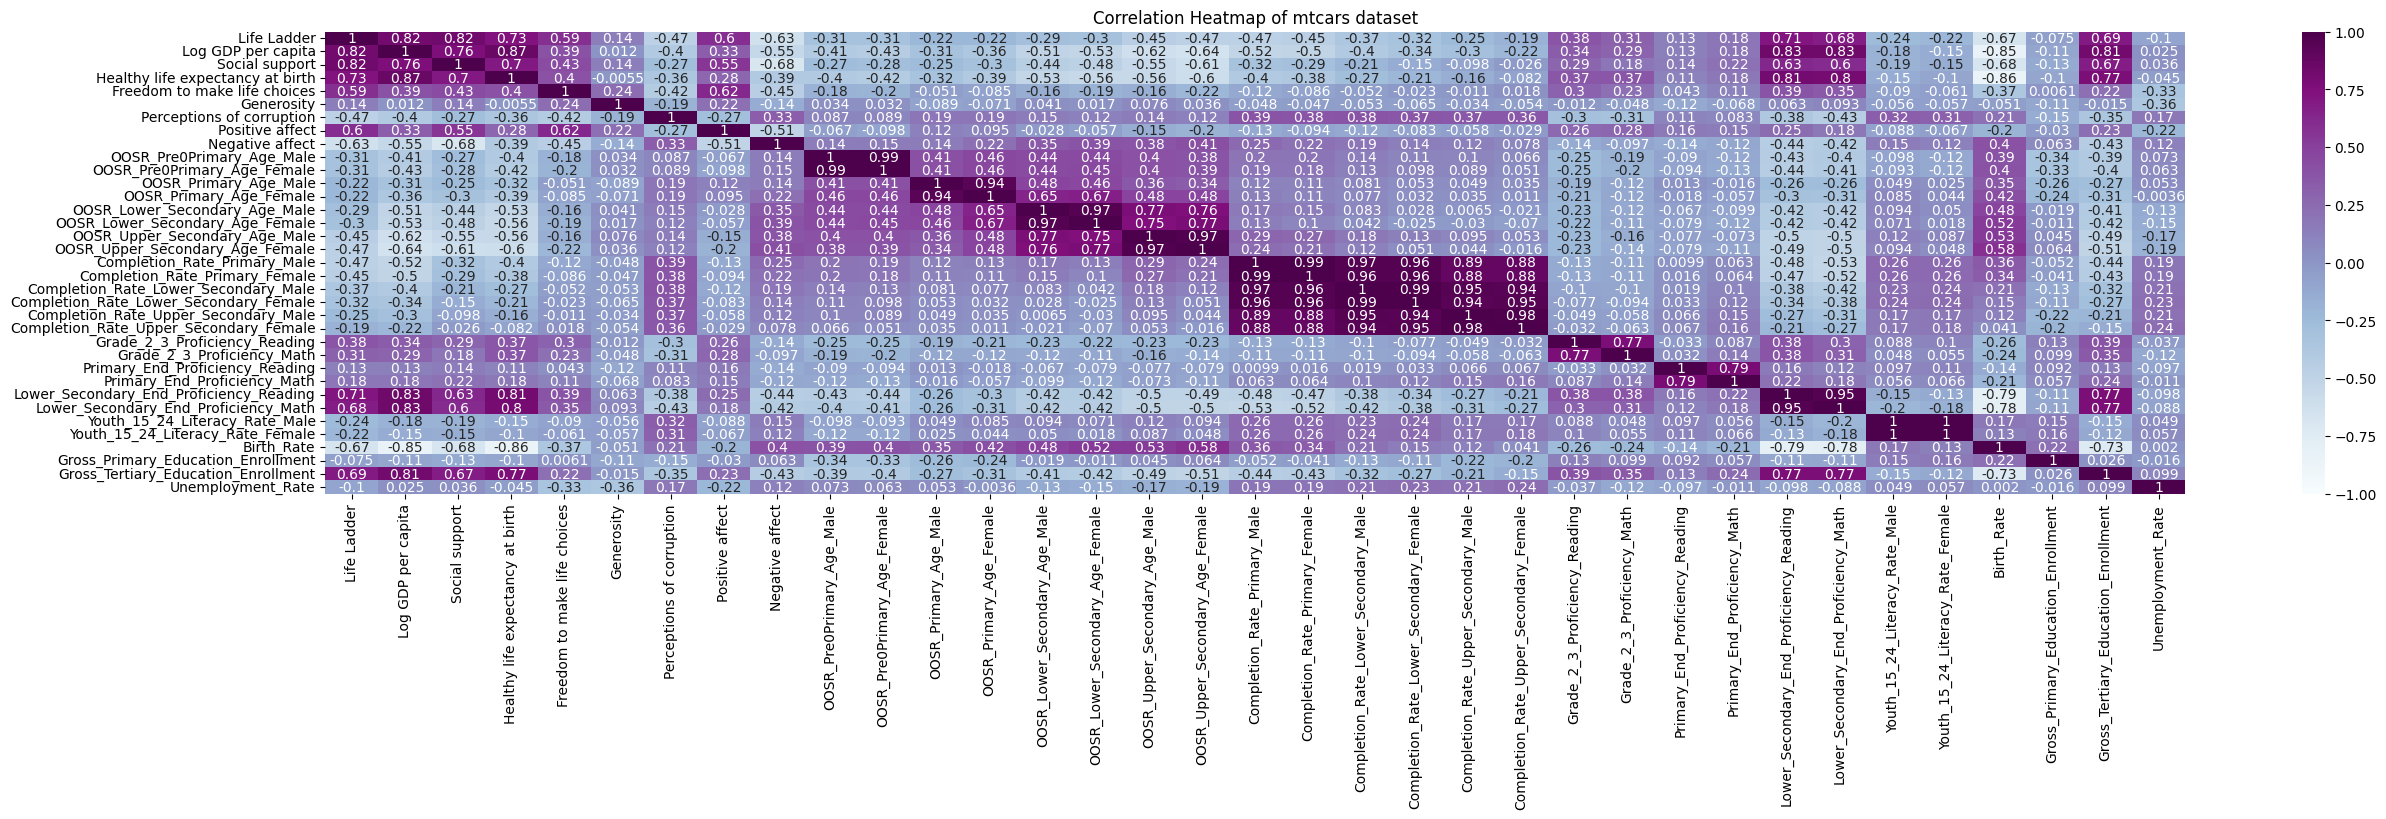

In [30]:
corr = merged.corr()
plt.figure(figsize=(30,6))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="BuPu",
            vmin=-1,
            vmax=1,
            annot=True)
plt.title("Correlation Heatmap of mtcars dataset")
plt.show()

From the above heatmap we can see there is high correlation between life ladder and the following: Log GPD per capita, Social support, Healthy life expectancy at birth, Lower_Secondary_End_Proficiency_Reading, Gross_Tertiary_Education_Enrollment, and Lower_Secondary_End_Proficiency_Math

In [31]:
selected_features = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Lower_Secondary_End_Proficiency_Reading', 'Gross_Tertiary_Education_Enrollment', 'Lower_Secondary_End_Proficiency_Math']

#### 4.1.2 SelectKBest
 I also explored feature selction using scikit-learn module, as demonstrated in the tutorial 'How to Build a Predictive Model in Python?' (365 Data Science, 2022). It was necessaryy to remove the Generosity column as it contained negative values.

In [32]:

selected_features_table = merged_table.drop(columns=['Generosity'])

In [33]:
X= selected_features_table.iloc[:,2:]
Y= selected_features_table.iloc[:,1]

best_features= SelectKBest(score_func=r_regression, k= 6)
fit= best_features.fit(X,Y)

df_scores= pd.DataFrame(fit.scores_)
df_columns= pd.DataFrame(X.columns)

features_scores= pd.concat([df_columns, df_scores], axis=1)
features_scores.columns= ['Features', 'Score']
features_scores.sort_values(by = 'Score')

,Features,Score
29,Birth_Rate,-0.667044
6,Negative affect,-0.625404
14,OOSR_Upper_Secondary_Age_Female,-0.473554
4,Perceptions of corruption,-0.470306
15,Completion_Rate_Primary_Male,-0.468765
16,Completion_Rate_Primary_Female,-0.454433
13,OOSR_Upper_Secondary_Age_Male,-0.448428
17,Completion_Rate_Lower_Secondary_Male,-0.368934
18,Completion_Rate_Lower_Secondary_Female,-0.323096
8,OOSR_Pre0Primary_Age_Female,-0.314969


The above shows the top six features match the six features highlighted earlier as being the most correlated to the life ladder variable.

In [35]:
X_features = merged_table[selected_features]

### 4.2 Split the Dataset
Split the updated dataset into training and testing sets

In [36]:
features = merged_table.columns[1:]
target = merged_table.columns[1]
y = merged_table[target].values

X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

### 4.3 Choose Estimator
The next step was to create the Stochastic Gradient Descent (SGD) Regressor Model. I chose this model based on scikit-learn's machine learning map tutorial (scikit-learn, 2024).
This estimator also highlighted the Lasso linear regression option as potentially relevant for my project. I decided to implement and evaluate both to see which would be the better fit.

#### 4.3.1 Create and train the SGD Model

In [40]:

sgd_model = SGDRegressor()
sgd_model.fit(X_train, y_train)

SGDRegressor()

#### 4.3.2 Create and train the Lasso Model
Use the lasso model to ... (Saturn Cloud, 2023)

In [39]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.1)

#### 4.3.3 Generate Predictions for both Models

In [41]:
sgd_predictions = sgd_model.predict(X_test)
lasso_predictions = lasso_model.predict(X_test)

# Stage 5 : Model Evaluation

## 5.1 Evaluate by Calculating Mean Squared Error(MSE)
Calculate MSE to measure the distance between the actual and predicted values for both the SGD model and the Lasso model. 

In [42]:
sgd_mse = mean_squared_error(y_test, sgd_predictions)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

In [43]:
print("SGD MSE:", sgd_mse)
print("Lasso MSE:", lasso_mse)

SGD MSE: 9.479036544291295e+25
Lasso MSE: 0.6382805294669477


The result shows a more accurate result for the Lasso model.

## 5.2 Evaluate by Calculating the R squared

Calculate the R squared which measures the 'goodness of fit' of a regression model.

In [44]:
sgd_r2 = r2_score(y_test, sgd_predictions)
lasso_r2 = r2_score(y_test, lasso_predictions)

In [45]:
print("SGD R2:", sgd_r2)
print("Lasso R2:", lasso_r2)

SGD R2: -6.200613400848813e+25
Lasso R2: 0.5824754144557913


The result shows a much beter 'goodness of fit' for the Lasso model.

## 5.3 Test using Unseen Data

In [70]:
new_data = pd.DataFrame({
    'Log GDP per capita': [8.2, 9.5, 7.8, 9.1],
    'Social support': [0.6, 0.8, 0.7, 8.0],
    'Healthy life expectancy at birth': [0.4, 0.3, 0.5, 8.6],
    'Lower_Secondary_End_Proficiency_Reading': [30, 50, 40, 20],
    'Gross_Tertiary_Education_Enrollment': [40, 60, 50, 30],
    'Lower_Secondary_End_Proficiency_Math': [0.7, 0.8, 0.6, 9.0]
})



In [71]:
lasso_predictions_new = lasso_model.predict(new_data)

print("Predicted life ladder values for the new data:")
print(lasso_predictions_new)

Predicted life ladder values for the new data:
[4.05968785 4.84813064 4.3076489  3.99605225]


In [69]:
sgd_predictions_new = sgd_model.predict(new_data)

print("Predicted life ladder values for the new data:")
print(sgd_predictions_new)

Predicted life ladder values for the new data:
[6.72578874e+12 1.00911353e+13 8.40377289e+12 5.14520351e+12]


# Stage 6
* Present results and Conclusions

# References
* scikit-learn. (2024). Machine Learning Map. [Online] Available at: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html [Accessed 15 April 2024].
* 365 Data Science. (Year). Predictive Model in Python. [Online] Available at: https://365datascience.com/tutorials/python-tutorials/predictive-model-python/ [Accessed 15 April 2024].
* Saturn Cloud. (Year). Python Classification with Lasso: How to Predict Classes. [Online] Available at: https://saturncloud.io/blog/python-classification-with-lasso-how-to-predict-classes/#:~:text=Feature%20Selection%3A%20Lasso%20automatically%20selects,feature%2Dto%2Dsample%20ratio. [Accessed 15 April 2024].

* https://scikit-learn.org/stable/modules/impute.html
* https://plotly.com/python/line-and-scatter/
* https://developer.ibm.com/tutorials/awb-lasso-regression-automatic-feature-selection/
* https://medium.com/@stephy.SD99/model-evaluation-for-classification-and-regression-analysis-6fa2d11a4a09